# Objective
The goal of this project is to build a **`multi-output`** image classification model for agricultural products using deep learning.

## Dataset Description:
The dataset is a **customized version** of the [Fruits-360](https://www.kaggle.com/datasets/moltean/fruits/data)
dataset.

Each image is annotated with the following attributes:

- `object_name:` Specific fruit or vegetable class (e.g., Apple red, Banana, Cucumber)

- `type:` High-level category (fruit, vegetable, nut)

- `defects_diseases:` Presence of defects (yes/no)

- `maturity_stage:` Ripeness status (unripe, ripen, overripe)


## We aim to:

- Train a baseline Convolutional Neural Network (CNN) model.

- Fine-tune a pretrained MobileNetV2 model for improved accuracy.

- Handle class imbalance using upsampling.

- Evaluate model performance using F1-score for each output.

-----------
# 01. Import Required Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.utils import shuffle
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

------
# 02. Load and Explore the Data
Since the dataset was customized locally, we uploaded it to Google Drive for easier access.

Our customization involved:

1. Renaming the folder structure

2. Grouping related images together

3. Labeling each folder with the following metadata:

  - object_name

  - type

  - defects_diseases

  - maturity_stage

This structure allows for multi-output classification, with each image belonging to a folder that defines all four labels.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [5]:
metadata = pd.read_csv("/content/dataset/metadata.csv")

In [6]:
metadata.head()

,folder_name,object_name,type,defects_diseases,maturity_stage
0,Apple defect,Apple red,fruit,yes,ripen
1,Apple gold,Apple gold,fruit,no,ripen
2,Apple gold defect,Apple gold,fruit,yes,ripen
3,Apple gold overripe,Apple gold,fruit,no,overripe
4,Apple green,Apple green,fruit,no,ripen


## 02.1. Create a DataFrame with corresponding labels

In [7]:
import os
import pandas as pd

def create_image_dataframe(root_dir, metadata_df, target_columns):
    """
    Creates a pandas DataFrame containing image paths and associated metadata.

    Args:
        root_dir (str): The root directory containing image subfolders.
        metadata_df (pd.DataFrame): The DataFrame containing the metadata,
                                     with a 'label' column for matching.
        target_columns (list): A list of column names from the metadata_df
                                to include in the output DataFrame.

    Returns:
        pd.DataFrame: A DataFrame with 'image_path' and the specified target columns.
    """
    data = []

    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Only process leaf directories (those containing images)
        image_files = [f for f in filenames if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if not image_files:
            continue

        # Use the last folder name in the path to match metadata
        folder_name = os.path.basename(dirpath)
        matched_rows = metadata_df[metadata_df['folder_name'].str.lower() == folder_name.lower()]
        if matched_rows.empty:
            print(f"Warning: No metadata found for {folder_name}")
            continue

        row = matched_rows.iloc[0]
        labels = {col: row[col] for col in target_columns}

        for fname in image_files:
            image_path = os.path.join(dirpath, fname)
            data.append({
                "image_path": image_path,
                **labels
            })

    return pd.DataFrame(data)

In [8]:
target_columns = [
    'maturity_stage', 'defects_diseases', 'type', 'object_name'
]

In [9]:
train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"

In [10]:
train_df = create_image_dataframe(train_dir, metadata, target_columns)
train_df.head()

,image_path,maturity_stage,defects_diseases,type,object_name
0,/content/dataset/train/vegetables/Tomato/Tomat...,ripen,yes,vegetable,Tomato
1,/content/dataset/train/vegetables/Tomato/Tomat...,ripen,yes,vegetable,Tomato
2,/content/dataset/train/vegetables/Tomato/Tomat...,ripen,yes,vegetable,Tomato
3,/content/dataset/train/vegetables/Tomato/Tomat...,ripen,yes,vegetable,Tomato
4,/content/dataset/train/vegetables/Tomato/Tomat...,ripen,yes,vegetable,Tomato


In [11]:
train_df.shape

(35418, 5)

In [12]:
test_cnn_df = create_image_dataframe(test_dir, metadata, target_columns)
test_cnn_df.shape

(7094, 5)

----------
# 03. Exploratory Data Analysis (EDA)

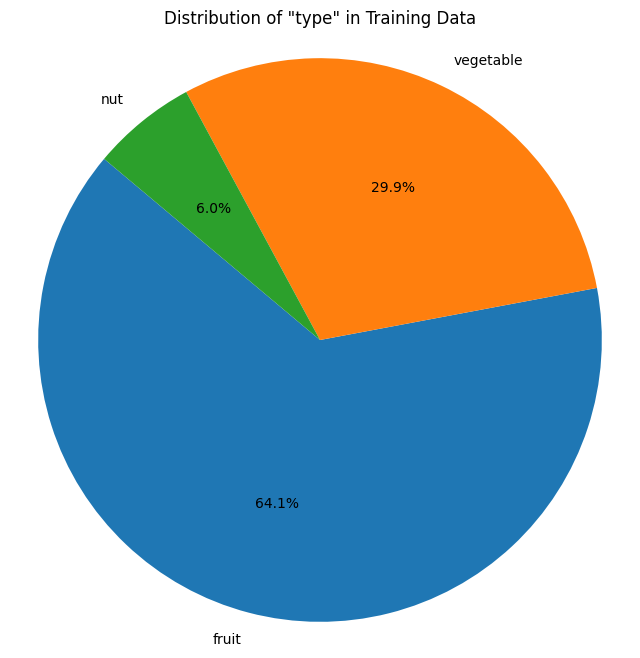

In [13]:
type_counts = train_df['type'].value_counts()
type_labels = type_counts.index

plt.figure(figsize=(8, 8))
plt.pie(type_counts, labels=type_labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of "type" in Training Data')
plt.axis('equal')
plt.show()

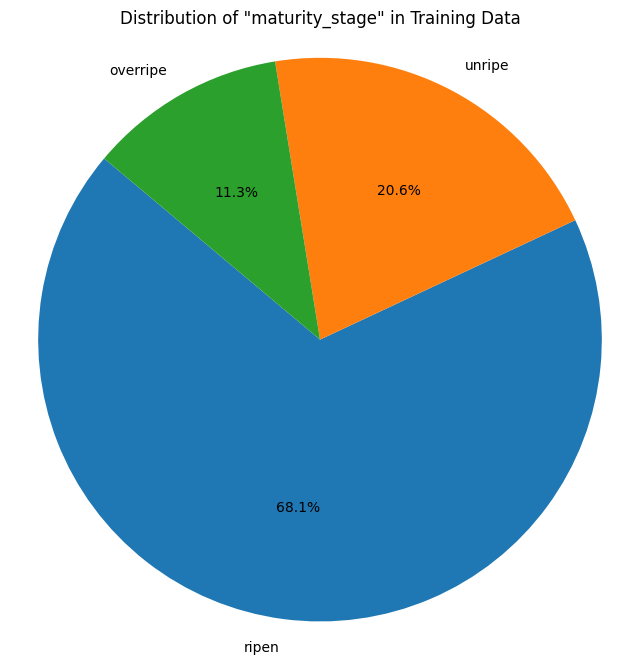

In [14]:
import matplotlib.pyplot as plt
maturity_counts = train_df['maturity_stage'].value_counts()
maturity_labels = maturity_counts.index

plt.figure(figsize=(8, 8))
plt.pie(maturity_counts, labels=maturity_labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of "maturity_stage" in Training Data')
plt.axis('equal')
plt.show()

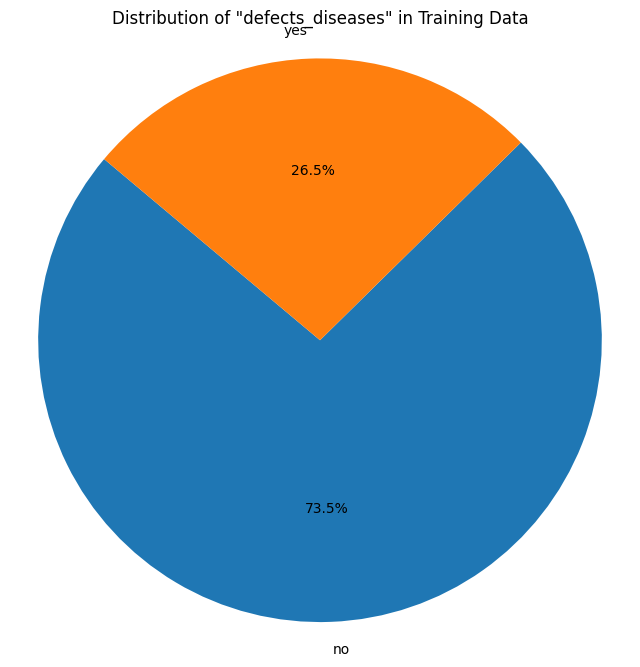

In [15]:
defects_diseases_counts = train_df['defects_diseases'].value_counts()
defects_diseases_labels = defects_diseases_counts.index

plt.figure(figsize=(8, 8))
plt.pie(defects_diseases_counts, labels=defects_diseases_labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of "defects_diseases" in Training Data')
plt.axis('equal')
plt.show()


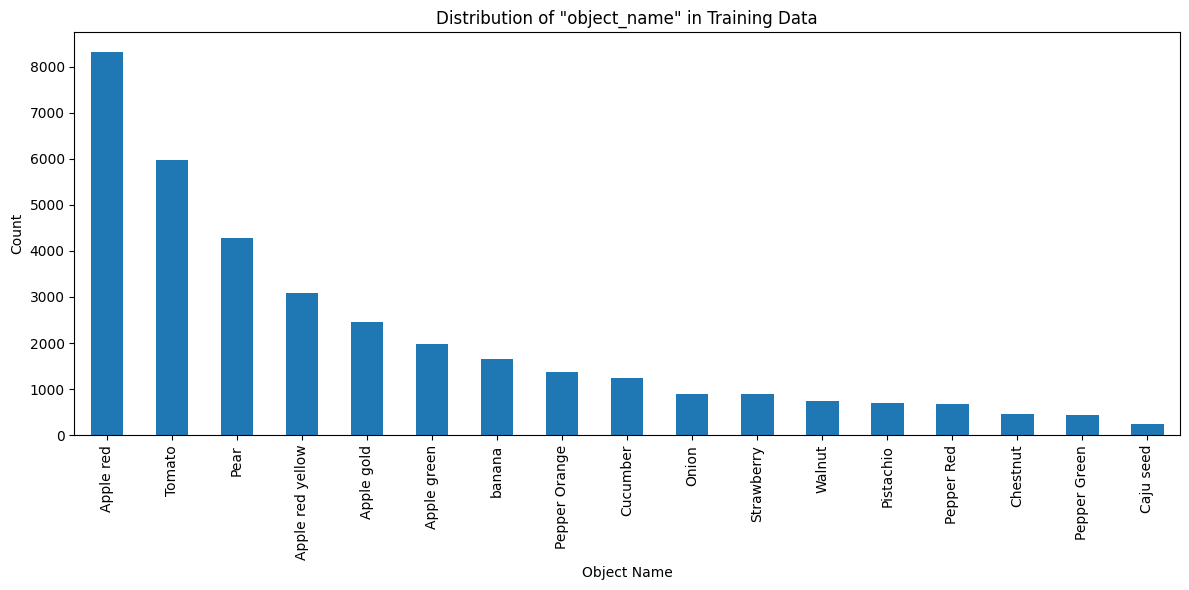

In [16]:
object_name_counts = train_df['object_name'].value_counts()
plt.figure(figsize=(12, 6))
object_name_counts.plot(kind='bar')
plt.title('Distribution of "object_name" in Training Data')
plt.xlabel('Object Name')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

--------------
# 04. Data Preprocessing

## `i.` Data split into: Train/Validation/Test
we will use it only on **Fine-Tuned model** to evaluate the effect of this technique compared to a manual split.

The reason for this is that the **manual split** in the original dataset resulted in **data leakage**, where similar or even identical images appear in both the training and test sets. This leakage leads to **artificially high accuracy**, which does not reflect the true generalization performance of the model.

In [17]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['object_name'])
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['object_name'])

print(f"Training set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Test set shape: {test_df.shape}")

Training set shape: (22667, 5)
Validation set shape: (7084, 5)
Test set shape: (5667, 5)


## `ii.` Label encoding

In [18]:
# Label Encoding
encoder_maturity = LabelEncoder()
encoder_defects = LabelEncoder()
encoder_type = LabelEncoder()
encoder_object = LabelEncoder()

train_df['maturity_stage_encoded'] = encoder_maturity.fit_transform(train_df['maturity_stage'])
val_df['maturity_stage_encoded'] = encoder_maturity.transform(val_df['maturity_stage'])
test_df['maturity_stage_encoded'] = encoder_maturity.transform(test_df['maturity_stage'])
test_cnn_df['maturity_stage_encoded'] = encoder_maturity.transform(test_cnn_df['maturity_stage'])

train_df['defects_diseases_encoded'] = encoder_defects.fit_transform(train_df['defects_diseases'])
val_df['defects_diseases_encoded'] = encoder_defects.transform(val_df['defects_diseases'])
test_df['defects_diseases_encoded'] = encoder_defects.transform(test_df['defects_diseases'])
test_cnn_df['defects_diseases_encoded'] = encoder_defects.transform(test_cnn_df['defects_diseases'])

train_df['type_encoded'] = encoder_type.fit_transform(train_df['type'])
val_df['type_encoded'] = encoder_type.transform(val_df['type'])
test_df['type_encoded'] = encoder_type.transform(test_df['type'])
test_cnn_df['type_encoded'] = encoder_type.transform(test_cnn_df['type'])

train_df['object_name_encoded'] = encoder_object.fit_transform(train_df['object_name'])
val_df['object_name_encoded'] = encoder_object.transform(val_df['object_name'])
test_df['object_name_encoded'] = encoder_object.transform(test_df['object_name'])
test_cnn_df['object_name_encoded'] = encoder_object.transform(test_cnn_df['object_name'])

# To get the classes names later
maturity_classes = encoder_maturity.classes_
defects_classes = encoder_defects.classes_
type_classes = encoder_type.classes_
object_classes = encoder_object.classes_

In [19]:
print("Encoded train_df head:")
train_df.head()

Encoded train_df head:


,image_path,maturity_stage,defects_diseases,type,object_name,maturity_stage_encoded,defects_diseases_encoded,type_encoded,object_name_encoded
12019,/content/dataset/train/nut/Walnut/r2_304_100.jpg,ripen,no,nut,Walnut,1,0,1,15
3184,/content/dataset/train/vegetables/Tomato/Tomat...,ripen,no,vegetable,Tomato,1,0,2,14
19873,/content/dataset/train/fruit/Apple/Apple red Y...,ripen,no,fruit,Apple red yellow,1,0,0,3
16917,/content/dataset/train/fruit/Apple/Apple unrip...,unripe,yes,fruit,Apple red,2,1,0,2
9532,/content/dataset/train/vegetables/Pepper/Peppe...,ripen,no,vegetable,Pepper Orange,1,0,2,10


In [20]:
print("\nMaturity Classes:", maturity_classes)
print("Defects/Diseases Classes:", defects_classes)
print("Type Classes:", type_classes)
print("Object Classes:", object_classes, len(object_classes))


Maturity Classes: ['overripe' 'ripen' 'unripe']
Defects/Diseases Classes: ['no' 'yes']
Type Classes: ['fruit' 'nut' 'vegetable']
Object Classes: ['Apple gold' 'Apple green' 'Apple red' 'Apple red yellow' 'Caju seed'
 'Chestnut' 'Cucumber' 'Onion' 'Pear' 'Pepper Green' 'Pepper Orange'
 'Pepper Red' 'Pistachio' 'Strawberry' 'Tomato' 'Walnut' 'banana'] 17


In [21]:
train_df = train_df.drop(['maturity_stage', 'defects_diseases', 'type', 'object_name'], axis=1)
val_df = val_df.drop(['maturity_stage', 'defects_diseases', 'type', 'object_name'], axis=1)
test_df = test_df.drop(['maturity_stage', 'defects_diseases', 'type', 'object_name'], axis=1)
test_cnn_df = test_cnn_df.drop(['maturity_stage', 'defects_diseases', 'type', 'object_name'], axis=1)

train_df = train_df.rename(columns={
    'maturity_stage_encoded': 'maturity_stage',
    'defects_diseases_encoded': 'defects_diseases',
    'type_encoded': 'type',
    'object_name_encoded': 'object_name'
})

val_df = val_df.rename(columns={
    'maturity_stage_encoded': 'maturity_stage',
    'defects_diseases_encoded': 'defects_diseases',
    'type_encoded': 'type',
    'object_name_encoded': 'object_name'
})

test_df = test_df.rename(columns={
    'maturity_stage_encoded': 'maturity_stage',
    'defects_diseases_encoded': 'defects_diseases',
    'type_encoded': 'type',
    'object_name_encoded': 'object_name'
})

test_cnn_df = test_cnn_df.rename(columns={
    'maturity_stage_encoded': 'maturity_stage',
    'defects_diseases_encoded': 'defects_diseases',
    'type_encoded': 'type',
    'object_name_encoded': 'object_name'
})

train_df.head()

,image_path,maturity_stage,defects_diseases,type,object_name
12019,/content/dataset/train/nut/Walnut/r2_304_100.jpg,1,0,1,15
3184,/content/dataset/train/vegetables/Tomato/Tomat...,1,0,2,14
19873,/content/dataset/train/fruit/Apple/Apple red Y...,1,0,0,3
16917,/content/dataset/train/fruit/Apple/Apple unrip...,2,1,0,2
9532,/content/dataset/train/vegetables/Pepper/Peppe...,1,0,2,10


In [22]:
# Separate the data into train and validation sets
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")
print(f"Test set cnn size: {len(test_cnn_df)}")

Training set size: 22667
Validation set size: 7084
Test set size: 5667
Test set cnn size: 7094


In [23]:
# Print the mapping of number to class for 'object_name'
print("\nObject Name Class Encoding:")
for i, class_name in enumerate(object_classes):
  print(f"{i}: {class_name}")

# Print the mapping of number to class for 'object_name'
print("\nObject Name Class Encoding:")
for i, class_name in enumerate(type_classes):
  print(f"{i}: {class_name}")

# Print the mapping of number to class for 'object_name'
print("\nObject Name Class Encoding:")
for i, class_name in enumerate(defects_classes):
  print(f"{i}: {class_name}")

# Print the mapping of number to class for 'object_name'
print("\nObject Name Class Encoding:")
for i, class_name in enumerate(maturity_classes):
  print(f"{i}: {class_name}")


Object Name Class Encoding:
0: Apple gold
1: Apple green
2: Apple red
3: Apple red yellow
4: Caju seed
5: Chestnut
6: Cucumber
7: Onion
8: Pear
9: Pepper Green
10: Pepper Orange
11: Pepper Red
12: Pistachio
13: Strawberry
14: Tomato
15: Walnut
16: banana

Object Name Class Encoding:
0: fruit
1: nut
2: vegetable

Object Name Class Encoding:
0: no
1: yes

Object Name Class Encoding:
0: overripe
1: ripen
2: unripe


In [24]:
for col in ['maturity_stage', 'defects_diseases', 'type', 'object_name']:
    print(train_df[col].value_counts(normalize=True))  # Get class balance

maturity_stage
1    0.679622
2    0.207129
0    0.113248
Name: proportion, dtype: float64
defects_diseases
0    0.735695
1    0.264305
Name: proportion, dtype: float64
type
0    0.640711
2    0.299157
1    0.060131
Name: proportion, dtype: float64
object_name
2     0.235232
14    0.168880
8     0.121013
3     0.087396
0     0.069131
1     0.056073
16    0.046940
10    0.038602
6     0.035029
7     0.025279
13    0.024926
15    0.020735
12    0.019720
11    0.018838
5     0.012706
9     0.012529
4     0.006970
Name: proportion, dtype: float64


## `iii.` Handling class imbalance
Upsampling for minority classes

In [25]:
def oversample_all_minority_classes(df, label_column):
    # Find class counts
    class_counts = df[label_column].value_counts()
    max_count = class_counts.max()

    oversampled_dfs = []

    for cls, count in class_counts.items():
        cls_df = df[df[label_column] == cls]
        if count < max_count:
            # Oversample minority class to max_count with replacement
            oversampled_cls_df = cls_df.sample(max_count, replace=True, random_state=42)
        else:
            # Majority class, keep as is
            oversampled_cls_df = cls_df
        oversampled_dfs.append(oversampled_cls_df)

    # Combine all oversampled classes and shuffle
    balanced_df = pd.concat(oversampled_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_df

In [26]:
# 50/50 Balance column
def oversample_minority_class(df, label_column, target_class):
    minority_df = df[df[label_column] == target_class]
    majority_df = df[df[label_column] != target_class]

    oversampled_minority = minority_df.sample(len(majority_df), replace=True, random_state=42)
    balanced_df = pd.concat([majority_df, oversampled_minority])
    return balanced_df.sample(frac=1).reset_index(drop=True)

In [27]:
# Balance dataset for specific label
train_balanced = oversample_all_minority_classes(train_df, 'maturity_stage')

In [28]:
train_balanced = oversample_minority_class(train_balanced, 'defects_diseases', target_class=1)

In [29]:
for col in ['maturity_stage', 'defects_diseases', 'type', 'object_name']:
    print(train_balanced[col].value_counts(normalize=True))
train_balanced.shape

maturity_stage
2    0.377881
0    0.318200
1    0.303919
Name: proportion, dtype: float64
defects_diseases
1    0.5
0    0.5
Name: proportion, dtype: float64
type
0    0.771856
2    0.207032
1    0.021112
Name: proportion, dtype: float64
object_name
2     0.376069
8     0.179012
14    0.128175
0     0.065474
3     0.056614
16    0.051611
1     0.031258
6     0.031072
9     0.014808
10    0.013553
7     0.012810
13    0.011818
15    0.007280
12    0.006924
11    0.006614
5     0.004461
4     0.002447
Name: proportion, dtype: float64


(64560, 5)

## `iiii.` Builds dataset from a DataFrame

In [30]:
IMG_SIZE = (100, 100)
BATCH_SIZE = 32

In [31]:
# List the classification columns you want as outputs
TARGETS = ['maturity_stage', 'defects_diseases', 'type', 'object_name']

Reads an image from a file, decodes it, resizes it to IMG_SIZE, and normalizes pixel values to [0, 1].

In [32]:
def decode_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

Returns the labels (as integers) for all target columns in a row.

In [33]:
def get_label(row):
    return {k: tf.cast(row[k], tf.int32) for k in TARGETS}

Applies random image augmentations

In [34]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomFlip("vertical"),
], name="data_augmentation")

In [35]:
def augment_image(image):
  return data_augmentation(image)

Builds a TensorFlow dataset from a DataFrame:

- Reads image paths and labels

- Decodes and augments images

- Batches, shuffles, and prefetches the data for performance

- Returns a ready-to-train `tf.data.Dataset`

In [36]:
def make_tf_dataset(df, shuffle=True, augment=False):
    filenames = df['image_path'].values
    labels = {k: df[k].values for k in TARGETS}

    ds = tf.data.Dataset.from_tensor_slices((filenames, labels))

    def process_path(file_path, label):
        img = decode_image(file_path)
        if augment:
            img = augment_image(img)
        return img, {k: label[k] for k in TARGETS}

    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1024)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

In [37]:
# Train with augmentation
train_cnn_ds = make_tf_dataset(train_df, shuffle=True, augment=False)
train_ds = make_tf_dataset(train_balanced, shuffle=True, augment=False)

In [38]:
# Validation/test for cnn model without augmentation
val_cnn_ds = make_tf_dataset(test_cnn_df, shuffle=False, augment=False)
test_cnn_ds = make_tf_dataset(test_cnn_df, shuffle=False, augment=False)

In [39]:
# Validation/test for pre-trained model without augmentation
val_ds = make_tf_dataset(val_df, shuffle=False, augment=False)
test_ds = make_tf_dataset(test_df, shuffle=False, augment=False)

In [40]:
print(f"Training set shape: {train_balanced.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Test set shape: {test_df.shape}")

Training set shape: (64560, 5)
Validation set shape: (7084, 5)
Test set shape: (5667, 5)


computes loss weights for each target label to handle class imbalance

In [41]:
def calculate_loss_weights(df, target_cols, max_clip=5.0):
    loss_weights = {}
    for col in target_cols:
        proportions = df[col].value_counts(normalize=True)
        min_prop = proportions.min()
        weight = 1 / min_prop
        loss_weights[col] = weight

    # Normalize weights by the smallest weight
    min_weight = min(loss_weights.values())
    for col in loss_weights:
        loss_weights[col] /= min_weight

    # Clip weights to max_clip
    for col in loss_weights:
        if loss_weights[col] > max_clip:
            loss_weights[col] = max_clip

    return loss_weights

In [42]:
target_cols = ['maturity_stage', 'defects_diseases', 'type', 'object_name']
loss_weights = calculate_loss_weights(train_df, target_cols)
print(loss_weights)

{'maturity_stage': 2.3338527463965715, 'defects_diseases': 1.0, 'type': 4.39545121056493, 'object_name': 5.0}


In [43]:
target_names_dict = {
    'maturity_stage': maturity_classes,
    'defects_diseases': defects_classes,
    'type': type_classes,
    'object_name': object_classes
}

--------------
# 05. Baseline CNN Model

In [ ]:
inputs = keras.Input(shape=(100, 100, 3))

# Feature extraction
x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)

# deeper feature extraction
x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)

# Global pooling and Dense layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)

outputs = {
    'defects_diseases': layers.Dense(1, activation='sigmoid', name='defects_diseases')(x),
    'type': layers.Dense(3, activation='softmax', name='type')(x),
    'maturity_stage': layers.Dense(3, activation='softmax', name='maturity_stage')(x),
    'object_name': layers.Dense(17, activation='softmax', name='object_name')(x)
}

cnn_model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 100,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 50, 50,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 50, 50,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 25, 25,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 25, 25,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 12,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ max_pooling2d_3[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    131,584 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defects_diseases    │ (None, 1)         │        513 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maturity_stage      │ (None, 3)         │      1,539 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ object_name (Dense) │ (None, 17)        │      8,721 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ type (Dense)        │ (None, 3)         │      1,539 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 532,312 (2.03 MB)

 Trainable params: 532,312 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
losses = {
    'defects_diseases': 'binary_crossentropy',
    'type': 'sparse_categorical_crossentropy',
    'maturity_stage': 'sparse_categorical_crossentropy',
    'object_name': 'sparse_categorical_crossentropy'

}

metrics = {
    'defects_diseases': 'accuracy',
    'type': 'accuracy',
    'maturity_stage': 'accuracy',
    'object_name': 'accuracy'
    }

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=losses,
    #loss_weights=loss_weights,
    metrics=metrics
)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_cnn_model.h5', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [ ]:
cnn_history = cnn_model.fit(
    train_cnn_ds,
    epochs=50,
    validation_data=val_cnn_ds,
    callbacks= callbacks
)

Epoch 1/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - defects_diseases_accuracy: 0.9891 - defects_diseases_loss: 0.0337 - loss: 0.0717 - maturity_stage_accuracy: 0.9938 - maturity_stage_loss: 0.0223 - object_name_accuracy: 0.9956 - object_name_loss: 0.0129 - type_accuracy: 0.9994 - type_loss: 0.0027

709/709 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - defects_diseases_accuracy: 0.9891 - defects_diseases_loss: 0.0337 - loss: 0.0717 - maturity_stage_accuracy: 0.9938 - maturity_stage_loss: 0.0223 - object_name_accuracy: 0.9956 - object_name_loss: 0.0130 - type_accuracy: 0.9994 - type_loss: 0.0027 - val_defects_diseases_accuracy: 0.9910 - val_defects_diseases_loss: 0.0251 - val_loss: 0.0391 - val_maturity_stage_accuracy: 0.9980 - val_maturity_stage_loss: 0.0059 - val_object_name_accuracy: 0.9976 - val_object_name_loss: 0.0071 - val_type_accuracy: 0.9994 - val_type_loss: 9.3391e-04 - learning_rate: 0.0010
Epoch 2/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - defects_diseases_accuracy: 0.9897 - defects_diseases_loss: 0.0276 - loss: 0.0549 - maturity_stage_accuracy: 0.9952 - maturity_stage_loss: 0.0146 - object_name_accuracy: 0.9966 - object_name_loss: 0.0104 - type_accuracy: 0.9994 - type_loss: 0.0024 - val_defects_diseases_accuracy: 0.9820 - val_defects_diseases_loss: 0.0536 - val_loss: 0.08

709/709 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - defects_diseases_accuracy: 0.9861 - defects_diseases_loss: 0.0380 - loss: 0.0719 - maturity_stage_accuracy: 0.9926 - maturity_stage_loss: 0.0194 - object_name_accuracy: 0.9958 - object_name_loss: 0.0133 - type_accuracy: 0.9997 - type_loss: 0.0012 - val_defects_diseases_accuracy: 0.9925 - val_defects_diseases_loss: 0.0209 - val_loss: 0.0359 - val_maturity_stage_accuracy: 0.9982 - val_maturity_stage_loss: 0.0069 - val_object_name_accuracy: 0.9983 - val_object_name_loss: 0.0059 - val_type_accuracy: 0.9996 - val_type_loss: 0.0022 - learning_rate: 0.0010
Epoch 4/50
708/709 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - defects_diseases_accuracy: 0.9895 - defects_diseases_loss: 0.0314 - loss: 0.0676 - maturity_stage_accuracy: 0.9919 - maturity_stage_loss: 0.0220 - object_name_accuracy: 0.9960 - object_name_loss: 0.0112 - type_accuracy: 0.9991 - type_loss: 0.0030

709/709 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - defects_diseases_accuracy: 0.9895 - defects_diseases_loss: 0.0314 - loss: 0.0675 - maturity_stage_accuracy: 0.9919 - maturity_stage_loss: 0.0220 - object_name_accuracy: 0.9960 - object_name_loss: 0.0112 - type_accuracy: 0.9991 - type_loss: 0.0030 - val_defects_diseases_accuracy: 0.9938 - val_defects_diseases_loss: 0.0175 - val_loss: 0.0289 - val_maturity_stage_accuracy: 0.9976 - val_maturity_stage_loss: 0.0070 - val_object_name_accuracy: 0.9982 - val_object_name_loss: 0.0043 - val_type_accuracy: 1.0000 - val_type_loss: 5.7596e-06 - learning_rate: 0.0010
Epoch 5/50
706/709 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - defects_diseases_accuracy: 0.9897 - defects_diseases_loss: 0.0285 - loss: 0.0587 - maturity_stage_accuracy: 0.9936 - maturity_stage_loss: 0.0162 - object_name_accuracy: 0.9958 - object_name_loss: 0.0134 - type_accuracy: 0.9999 - type_loss: 6.3456e-04

709/709 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - defects_diseases_accuracy: 0.9897 - defects_diseases_loss: 0.0285 - loss: 0.0587 - maturity_stage_accuracy: 0.9936 - maturity_stage_loss: 0.0162 - object_name_accuracy: 0.9959 - object_name_loss: 0.0134 - type_accuracy: 0.9999 - type_loss: 6.3660e-04 - val_defects_diseases_accuracy: 0.9965 - val_defects_diseases_loss: 0.0120 - val_loss: 0.0257 - val_maturity_stage_accuracy: 0.9975 - val_maturity_stage_loss: 0.0078 - val_object_name_accuracy: 0.9979 - val_object_name_loss: 0.0058 - val_type_accuracy: 1.0000 - val_type_loss: 1.2765e-05 - learning_rate: 0.0010
Epoch 6/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - defects_diseases_accuracy: 0.9896 - defects_diseases_loss: 0.0287 - loss: 0.0534 - maturity_stage_accuracy: 0.9938 - maturity_stage_loss: 0.0163 - object_name_accuracy: 0.9976 - object_name_loss: 0.0076 - type_accuracy: 0.9997 - type_loss: 8.3214e-04 - val_defects_diseases_accuracy: 0.9922 - val_defects_diseases_loss: 0.0194 - val_lo

709/709 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - defects_diseases_accuracy: 0.9948 - defects_diseases_loss: 0.0145 - loss: 0.0304 - maturity_stage_accuracy: 0.9970 - maturity_stage_loss: 0.0086 - object_name_accuracy: 0.9977 - object_name_loss: 0.0064 - type_accuracy: 0.9997 - type_loss: 9.0218e-04 - val_defects_diseases_accuracy: 0.9961 - val_defects_diseases_loss: 0.0119 - val_loss: 0.0187 - val_maturity_stage_accuracy: 0.9990 - val_maturity_stage_loss: 0.0040 - val_object_name_accuracy: 0.9992 - val_object_name_loss: 0.0028 - val_type_accuracy: 1.0000 - val_type_loss: 1.7859e-06 - learning_rate: 5.0000e-04
Epoch 10/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - defects_diseases_accuracy: 0.9960 - defects_diseases_loss: 0.0120 - loss: 0.0230 - maturity_stage_accuracy: 0.9979 - maturity_stage_loss: 0.0065 - object_name_accuracy: 0.9990 - object_name_loss: 0.0035 - type_accuracy: 0.9999 - type_loss: 9.8573e-04 - val_defects_diseases_accuracy: 0.9934 - val_defects_diseases_loss: 0.0176 - v

709/709 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - defects_diseases_accuracy: 0.9945 - defects_diseases_loss: 0.0147 - loss: 0.0277 - maturity_stage_accuracy: 0.9977 - maturity_stage_loss: 0.0060 - object_name_accuracy: 0.9982 - object_name_loss: 0.0063 - type_accuracy: 0.9998 - type_loss: 6.8066e-04 - val_defects_diseases_accuracy: 0.9977 - val_defects_diseases_loss: 0.0072 - val_loss: 0.0139 - val_maturity_stage_accuracy: 0.9984 - val_maturity_stage_loss: 0.0039 - val_object_name_accuracy: 0.9987 - val_object_name_loss: 0.0028 - val_type_accuracy: 1.0000 - val_type_loss: 2.3111e-06 - learning_rate: 5.0000e-04
Epoch 12/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - defects_diseases_accuracy: 0.9955 - defects_diseases_loss: 0.0115 - loss: 0.0212 - maturity_stage_accuracy: 0.9977 - maturity_stage_loss: 0.0062 - object_name_accuracy: 0.9987 - object_name_loss: 0.0035 - type_accuracy: 1.0000 - type_loss: 7.3150e-05 - val_defects_diseases_accuracy: 0.9962 - val_defects_diseases_loss: 0.0120 - v

 ## Evaluation and Metrics

In [44]:
def calculate_f1_scores(model, dataset, target_names_dict):
    """
    Calculates F1 scores for each output of the multi-output model on a dataset.

    Args:
        model (tf.keras.Model): The trained multi-output model.
        dataset (tf.data.Dataset): The dataset to evaluate on.
        target_names_dict (dict): A dictionary mapping target names to their corresponding
                                   list of class names (e.g., {'object_name': object_classes}).

    Returns:
        dict: A dictionary where keys are target names and values are their
              corresponding F1 scores.
    """
    predictions = model.predict(dataset)
    true_labels = {}
    # Iterate through the dataset once to get true labels
    for _, labels in dataset:
        for target_name in target_names_dict.keys():
            if target_name not in true_labels:
                true_labels[target_name] = []
            true_labels[target_name].extend(labels[target_name].numpy())

    f1_scores = {}
    for target_name, class_names in target_names_dict.items():
        true_y = np.array(true_labels[target_name])
        pred_y = predictions[target_name]

        if pred_y.shape[-1] == 1: # Binary classification
            pred_y_classes = (pred_y > 0.5).astype(int).flatten()
            # For binary classification, can use 'binary' or 'f1_score(y_true, y_pred)'
            f1 = f1_score(true_y, pred_y_classes, average='binary')
        else: # Multiclass classification
            pred_y_classes = np.argmax(pred_y, axis=1)
            # Use 'weighted' average for multiclass F1 score
            f1 = f1_score(true_y, pred_y_classes, average='weighted')

        f1_scores[target_name] = f1

    return f1_scores

In [ ]:
test_f1_scores = calculate_f1_scores(cnn_model, test_cnn_ds, target_names_dict)

print("\nTest Set F1 Scores:")
for target, f1 in test_f1_scores.items():
    print(f"{target}: {f1:.4f}")

222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step

Test Set F1 Scores:
maturity_stage: 0.9985
defects_diseases: 0.9957
type: 1.0000
object_name: 0.9987


In [ ]:
history_dict = cnn_history.history

In [ ]:
# Print the final train and validation accuracies for each output
print("\nFinal training accuracies:")
for key in history_dict.keys():
    if 'accuracy' in key and not key.startswith('val_'):
        print(f"{key}: {history_dict[key][-1]:.4f}")


Final training accuracies:
defects_diseases_accuracy: 0.9971
maturity_stage_accuracy: 0.9984
object_name_accuracy: 0.9990
type_accuracy: 1.0000


In [ ]:
print("\nFinal validation accuracies:")
for key in history_dict.keys():
    if key.startswith('val_') and 'accuracy' in key:
        print(f"{key}: {history_dict[key][-1]:.4f}")


Final validation accuracies:
val_defects_diseases_accuracy: 0.9968
val_maturity_stage_accuracy: 0.9983
val_object_name_accuracy: 0.9983
val_type_accuracy: 1.0000


In [ ]:
# Evaluate the model on the test set
test_results = cnn_model.evaluate(test_cnn_ds)

# Access the values by their index
test_loss = test_results[0]
test_defects_diseases_acc = test_results[5] # Index 5 corresponds to defects_diseases_accuracy
test_type_acc = test_results[6] # Index 6 corresponds to type_accuracy
test_maturity_stage_acc = test_results[7] # Index 7 corresponds to maturity_stage_accuracy
test_object_name_acc = test_results[8] # Index 8 corresponds to object_name_accuracy

print("\nTest Set Evaluation:")
print(f"Test Defects/Diseases Accuracy: {test_defects_diseases_acc:.4f}")
print(f"Test Type Accuracy: {test_type_acc:.4f}")
print(f"Test Maturity Stage Accuracy: {test_maturity_stage_acc:.4f}")
print(f"Test Object Name Accuracy: {test_object_name_acc:.4f}")

222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - defects_diseases_accuracy: 0.9976 - defects_diseases_loss: 0.0071 - loss: 0.0128 - maturity_stage_accuracy: 0.9989 - maturity_stage_loss: 0.0042 - object_name_accuracy: 0.9993 - object_name_loss: 0.0015 - type_accuracy: 1.0000 - type_loss: 7.5467e-06

Test Set Evaluation:
Test Defects/Diseases Accuracy: 0.9977
Test Type Accuracy: 0.9984
Test Maturity Stage Accuracy: 0.9987
Test Object Name Accuracy: 1.0000


## CNN model Conclusion:
Although the CNN model achieved very high accuracy, the training behavior suggests overfitting rather than genuine learning. The model appears to memorize the training data without effectively generalizing to unseen samples.

These observations highlight a `lack of regularization` and true feature learning, suggesting that the model's performance is not reliable in real-world scenarios. To address this, techniques like data augmentation, dropout, weight decay, and more balanced splits (with no leakage) should be enforced more rigorously.

---------
# 06. MobileNetV2 Model (Fine-Tuned)

In [45]:
base_model = MobileNetV2(
    input_shape=(100, 100, 3),
    include_top=False,
    weights='imagenet'
)

<ipython-input-45-7bbb2eedfd1b>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [46]:
# preprocess_input = tf.keras.applications.resnet.preprocess_input
base_model.trainable = False

In [47]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomFlip("vertical"),
], name="data_augmentation")

In [48]:
inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
# Global pooling and Dense layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

outputs = {
    'defects_diseases': layers.Dense(1, activation='sigmoid', name='defects_diseases')(x),
    'type': layers.Dense(3, activation='softmax', name='type')(x),
    'maturity_stage': layers.Dense(3, activation='softmax', name='maturity_stage')(x),
    'object_name': layers.Dense(17, activation='softmax', name='object_name')(x)
}

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 100, 100,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 4, 4,      │  2,257,984 │ data_augmentatio… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    655,872 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defects_diseases    │ (None, 1)         │        513 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maturity_stage      │ (None, 3)         │      1,539 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ object_name (Dense) │ (None, 17)        │      8,721 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ type (Dense)        │ (None, 3)         │      1,539 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,928,216 (11.17 MB)

 Trainable params: 669,208 (2.55 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

In [49]:
losses = {
    'defects_diseases': 'binary_crossentropy',
    'type': 'sparse_categorical_crossentropy',
    'maturity_stage': 'sparse_categorical_crossentropy',
    'object_name': 'sparse_categorical_crossentropy'

}

metrics = {
    'defects_diseases': 'accuracy',
    'type': 'accuracy',
    'maturity_stage': 'accuracy',
    'object_name': 'accuracy'
    }

loss_weights = {
    'defects_diseases': 2.0,
    'type': 1.5,
    'maturity_stage': 2.5,
    'object_name': 2.5
}
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses,
    loss_weights=loss_weights,
    metrics=metrics

)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [ ]:
history_phase1 = model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    callbacks= callbacks
)

Epoch 1/15
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 90s 38ms/step - defects_diseases_accuracy: 0.5270 - defects_diseases_loss: 0.7925 - loss: 16.9516 - maturity_stage_accuracy: 0.3620 - maturity_stage_loss: 1.3783 - object_name_accuracy: 0.2189 - object_name_loss: 2.8252 - type_accuracy: 0.5276 - type_loss: 1.1135 - val_defects_diseases_accuracy: 0.6314 - val_defects_diseases_loss: 1.2423 - val_loss: 27.4864 - val_maturity_stage_accuracy: 0.4217 - val_maturity_stage_loss: 2.8605 - val_object_name_accuracy: 0.3787 - val_object_name_loss: 5.0201 - val_type_accuracy: 0.7516 - val_type_loss: 1.8085 - learning_rate: 1.0000e-04
Epoch 2/15
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 66s 33ms/step - defects_diseases_accuracy: 0.5584 - defects_diseases_loss: 0.6980 - loss: 12.4516 - maturity_stage_accuracy: 0.3985 - maturity_stage_loss: 1.1434 - object_name_accuracy: 0.4207 - object_name_loss: 1.9225 - type_accuracy: 0.7714 - type_loss: 0.6289 - val_defects_diseases_accuracy: 0.6670 - val_defects_diseases_loss: 1.014

In [51]:
def suggest_loss_weights(f1_scores, class_distributions, cap=2.5):
    """
    Suggest loss weights based on class imbalance and F1 score.

    Args:
        f1_scores (dict): F1 scores per output.
        class_distributions (dict): Dict with max class proportion per output.
        cap (float): Max allowed weight to avoid instability.

    Returns:
        dict: Recommended loss weights.
    """
    loss_weights = {}
    for target in f1_scores:
        imbalance = 1.0 / class_distributions[target]  # Inverse of majority class % (0.6 -> ~1.67)
        penalty = 1.0 / max(f1_scores[target], 1e-6)    # Avoid div by zero
        weight = min(imbalance * penalty, cap)
        loss_weights[target] = round(weight, 2)
    return loss_weights

In [52]:
max_proportions = {}
for col in ['maturity_stage', 'defects_diseases', 'type', 'object_name']:
    max_proportions[col] = train_balanced[col].value_counts(normalize=True).max()

In [53]:
print(max_proportions)

{'maturity_stage': 0.3778810408921933, 'defects_diseases': 0.5, 'type': 0.7718556381660471, 'object_name': 0.37606877323420074}


In [ ]:
test_f1_scores = calculate_f1_scores(model, test_ds, target_names_dict)

print("\nTest Set F1 Scores:")
for target, f1 in test_f1_scores.items():
    print(f"{target}: {f1:.4f}")

178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step

Test Set F1 Scores:
maturity_stage: 0.5630
defects_diseases: 0.5946
type: 0.8357
object_name: 0.6632


In [ ]:
# Suggest new weights
updated_loss_weights = suggest_loss_weights(test_f1_scores, max_proportions)

print("\n Suggested loss weights:")
print(updated_loss_weights)


 Suggested loss weights:
{'maturity_stage': 2.5, 'defects_diseases': 2.5, 'type': 1.55, 'object_name': 2.5}


In [ ]:
# Unfreeze last 20% of layers
total_layers = len(base_model.layers)
unfreeze_layers = int(total_layers * 0.20)

for layer in base_model.layers[-unfreeze_layers:]:
    layer.trainable = True

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses,
    metrics=metrics,
    loss_weights=updated_loss_weights
    )

In [ ]:
history_phase2 = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks= callbacks
)

Epoch 1/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 104s 45ms/step - defects_diseases_accuracy: 0.5808 - defects_diseases_loss: 0.6539 - loss: 9.5802 - maturity_stage_accuracy: 0.4397 - maturity_stage_loss: 1.0452 - object_name_accuracy: 0.4709 - object_name_loss: 1.7121 - type_accuracy: 0.7937 - type_loss: 0.5557 - val_defects_diseases_accuracy: 0.6724 - val_defects_diseases_loss: 0.5906 - val_loss: 8.0951 - val_maturity_stage_accuracy: 0.4538 - val_maturity_stage_loss: 1.0028 - val_object_name_accuracy: 0.5392 - val_object_name_loss: 1.2529 - val_type_accuracy: 0.7993 - val_type_loss: 0.5225 - learning_rate: 1.0000e-04
Epoch 2/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 89s 44ms/step - defects_diseases_accuracy: 0.6175 - defects_diseases_loss: 0.6147 - loss: 8.7818 - maturity_stage_accuracy: 0.4831 - maturity_stage_loss: 0.9765 - object_name_accuracy: 0.5115 - object_name_loss: 1.5399 - type_accuracy: 0.8088 - type_loss: 0.5077 - val_defects_diseases_accuracy: 0.7688 - val_defects_diseases_loss: 0.4597 

In [ ]:
test_f1_scores = calculate_f1_scores(model, test_ds, target_names_dict)

print("\nTest Set F1 Scores:")
for target, f1 in test_f1_scores.items():
    print(f"{target}: {f1:.4f}")

178/178 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step

Test Set F1 Scores:
maturity_stage: 0.7588
defects_diseases: 0.7737
type: 0.9269
object_name: 0.7885


In [ ]:
# Suggest new weights
updated_loss_weights = suggest_loss_weights(test_f1_scores, max_proportions)

print("\n Suggested loss weights:")
print(updated_loss_weights)


 Suggested loss weights:
{'maturity_stage': 2.5, 'defects_diseases': 2.5, 'type': 1.4, 'object_name': 2.5}


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses,
    metrics=metrics,
    loss_weights=updated_loss_weights
    )

In [ ]:
history_phase3 = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks= callbacks
)

Epoch 1/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 109s 48ms/step - defects_diseases_accuracy: 0.6668 - defects_diseases_loss: 0.5391 - loss: 7.3638 - maturity_stage_accuracy: 0.5610 - maturity_stage_loss: 0.8284 - object_name_accuracy: 0.5834 - object_name_loss: 1.3130 - type_accuracy: 0.8439 - type_loss: 0.4205 - val_defects_diseases_accuracy: 0.8896 - val_defects_diseases_loss: 0.2632 - val_loss: 3.2721 - val_maturity_stage_accuracy: 0.8278 - val_maturity_stage_loss: 0.3876 - val_object_name_accuracy: 0.7885 - val_object_name_loss: 0.5364 - val_type_accuracy: 0.9342 - val_type_loss: 0.1633 - learning_rate: 1.0000e-04
Epoch 2/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 139s 47ms/step - defects_diseases_accuracy: 0.6680 - defects_diseases_loss: 0.5326 - loss: 7.3278 - maturity_stage_accuracy: 0.5624 - maturity_stage_loss: 0.8221 - object_name_accuracy: 0.5833 - object_name_loss: 1.3122 - type_accuracy: 0.8417 - type_loss: 0.4188 - val_defects_diseases_accuracy: 0.8816 - val_defects_diseases_loss: 0.2797

In [ ]:
model.save('multi_output_model_MobileNetV2_ph5_v3.keras')

In [ ]:
test_f1_scores = calculate_f1_scores(model, test_ds, target_names_dict)

print("\nTest Set F1 Scores:")
for target, f1 in test_f1_scores.items():
    print(f"{target}: {f1:.4f}")

178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step

Test Set F1 Scores:
maturity_stage: 0.8431
defects_diseases: 0.7805
type: 0.9564
object_name: 0.8527


In [ ]:
# Suggest new weights
updated_loss_weights = suggest_loss_weights(test_f1_scores, max_proportions)

print("\n Suggested loss weights:")
print(updated_loss_weights)


 Suggested loss weights:
{'maturity_stage': 2.5, 'defects_diseases': 2.5, 'type': 1.35, 'object_name': 2.5}


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses,
    metrics=metrics,
    loss_weights=updated_loss_weights
    )

In [ ]:
history_phase4 = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks= callbacks

)

Epoch 1/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 123s 52ms/step - defects_diseases_accuracy: 0.6769 - defects_diseases_loss: 0.5188 - loss: 7.0714 - maturity_stage_accuracy: 0.5733 - maturity_stage_loss: 0.7987 - object_name_accuracy: 0.6021 - object_name_loss: 1.2632 - type_accuracy: 0.8498 - type_loss: 0.4059 - val_defects_diseases_accuracy: 0.8851 - val_defects_diseases_loss: 0.2780 - val_loss: 3.3333 - val_maturity_stage_accuracy: 0.8274 - val_maturity_stage_loss: 0.4484 - val_object_name_accuracy: 0.8353 - val_object_name_loss: 0.4827 - val_type_accuracy: 0.9466 - val_type_loss: 0.1747 - learning_rate: 1.0000e-04
Epoch 2/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 136s 49ms/step - defects_diseases_accuracy: 0.6767 - defects_diseases_loss: 0.5233 - loss: 7.1145 - maturity_stage_accuracy: 0.5738 - maturity_stage_loss: 0.8008 - object_name_accuracy: 0.5978 - object_name_loss: 1.2749 - type_accuracy: 0.8487 - type_loss: 0.4031 - val_defects_diseases_accuracy: 0.8862 - val_defects_diseases_loss: 0.2624

In [ ]:
model.save('multi_output_model_MobileNetV2_ph4_v5.keras')

In [ ]:
test_f1_scores = calculate_f1_scores(model, test_ds, target_names_dict)

print("\nTest Set F1 Scores:")
for target, f1 in test_f1_scores.items():
    print(f"{target}: {f1:.4f}")

178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step

Test Set F1 Scores:
maturity_stage: 0.8711
defects_diseases: 0.8152
type: 0.9842
object_name: 0.8877


In [ ]:
# Suggest new weights
updated_loss_weights = suggest_loss_weights(test_f1_scores, max_proportions)

print("\n Suggested loss weights:")
print(updated_loss_weights)


 Suggested loss weights:
{'maturity_stage': 2.5, 'defects_diseases': 2.45, 'type': 1.32, 'object_name': 2.5}


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses,
    metrics=metrics,
    loss_weights=updated_loss_weights
    )

In [ ]:
history_phase5 = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks= callbacks
)

Epoch 1/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 120s 50ms/step - defects_diseases_accuracy: 0.6820 - defects_diseases_loss: 0.5115 - loss: 6.8972 - maturity_stage_accuracy: 0.5872 - maturity_stage_loss: 0.7752 - object_name_accuracy: 0.6063 - object_name_loss: 1.2477 - type_accuracy: 0.8521 - type_loss: 0.3958 - val_defects_diseases_accuracy: 0.9019 - val_defects_diseases_loss: 0.2421 - val_loss: 2.3679 - val_maturity_stage_accuracy: 0.8700 - val_maturity_stage_loss: 0.2999 - val_object_name_accuracy: 0.8869 - val_object_name_loss: 0.3353 - val_type_accuracy: 0.9719 - val_type_loss: 0.0906 - learning_rate: 1.0000e-04
Epoch 2/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 97s 48ms/step - defects_diseases_accuracy: 0.6828 - defects_diseases_loss: 0.5071 - loss: 6.8376 - maturity_stage_accuracy: 0.5895 - maturity_stage_loss: 0.7684 - object_name_accuracy: 0.6107 - object_name_loss: 1.2366 - type_accuracy: 0.8548 - type_loss: 0.3898 - val_defects_diseases_accuracy: 0.8951 - val_defects_diseases_loss: 0.2475 

In [ ]:
model.save('multi_output_model_MobileNetV2_ph5_v5.keras')

In [ ]:
test_f1_scores = calculate_f1_scores(model, test_ds, target_names_dict)

print("\nTest Set F1 Scores:")
for target, f1 in test_f1_scores.items():
    print(f"{target}: {f1:.4f}")

178/178 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step

Test Set F1 Scores:
maturity_stage: 0.8808
defects_diseases: 0.8196
type: 0.9754
object_name: 0.8857


In [ ]:
# Suggest new weights
updated_loss_weights = suggest_loss_weights(test_f1_scores, max_proportions)

print("\n Suggested loss weights:")
print(updated_loss_weights)


 Suggested loss weights:
{'maturity_stage': 2.5, 'defects_diseases': 2.44, 'type': 1.33, 'object_name': 2.5}


In [ ]:
# Access the base_model from the loaded model
base_model = None
for layer in model.layers:
    if isinstance(layer, tf.keras.Model) and "mobilenetv2" in layer.name.lower():
        base_model = layer
        break

if base_model:
    # Unfreeze the last 25% of layers in base_model
    total_layers = len(base_model.layers)
    unfreeze_layers = int(total_layers * 0.25)

    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    print(f"Unfroze last {unfreeze_layers} layers of {base_model.name}.")
else:
    print("❌ MobileNetV2 base model not found inside loaded model.")

Unfroze last 38 layers of mobilenetv2_1.00_224.


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses,
    metrics=metrics,
    loss_weights=updated_loss_weights
    )

In [ ]:
history_phase6 = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks= callbacks
)

Epoch 1/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 130s 55ms/step - defects_diseases_accuracy: 0.6475 - defects_diseases_loss: 0.5726 - loss: 7.8599 - maturity_stage_accuracy: 0.5298 - maturity_stage_loss: 0.8931 - object_name_accuracy: 0.5531 - object_name_loss: 1.4203 - type_accuracy: 0.8305 - type_loss: 0.4609 - val_defects_diseases_accuracy: 0.8900 - val_defects_diseases_loss: 0.2641 - val_loss: 3.0571 - val_maturity_stage_accuracy: 0.8118 - val_maturity_stage_loss: 0.4284 - val_object_name_accuracy: 0.8365 - val_object_name_loss: 0.4481 - val_type_accuracy: 0.9643 - val_type_loss: 0.1150 - learning_rate: 1.0000e-04
Epoch 2/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 114s 56ms/step - defects_diseases_accuracy: 0.6740 - defects_diseases_loss: 0.5272 - loss: 7.1676 - maturity_stage_accuracy: 0.5706 - maturity_stage_loss: 0.8115 - object_name_accuracy: 0.5976 - object_name_loss: 1.2948 - type_accuracy: 0.8473 - type_loss: 0.4116 - val_defects_diseases_accuracy: 0.8799 - val_defects_diseases_loss: 0.2899

In [ ]:
test_f1_scores = calculate_f1_scores(model, test_ds, target_names_dict)

print("\nTest Set F1 Scores:")
for target, f1 in test_f1_scores.items():
    print(f"{target}: {f1:.4f}")

178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step

Test Set F1 Scores:
maturity_stage: 0.8936
defects_diseases: 0.8318
type: 0.9613
object_name: 0.8640


In [ ]:
# Suggest new weights
updated_loss_weights = suggest_loss_weights(test_f1_scores, max_proportions)

print("\n Suggested loss weights:")
print(updated_loss_weights)


 Suggested loss weights:
{'maturity_stage': 2.5, 'defects_diseases': 2.4, 'type': 1.35, 'object_name': 2.5}


In [ ]:
model.save('multi_output_model_MobileNetV2_ph6_v5.keras')

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses,
    metrics=metrics,
    loss_weights=updated_loss_weights
    )

In [ ]:
history_phase7 = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks= callbacks
)

Epoch 1/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 132s 57ms/step - defects_diseases_accuracy: 0.6939 - defects_diseases_loss: 0.4931 - loss: 6.6030 - maturity_stage_accuracy: 0.6030 - maturity_stage_loss: 0.7429 - object_name_accuracy: 0.6274 - object_name_loss: 1.1970 - type_accuracy: 0.8614 - type_loss: 0.3790 - val_defects_diseases_accuracy: 0.8899 - val_defects_diseases_loss: 0.2610 - val_loss: 2.8586 - val_maturity_stage_accuracy: 0.8677 - val_maturity_stage_loss: 0.3291 - val_object_name_accuracy: 0.8464 - val_object_name_loss: 0.4806 - val_type_accuracy: 0.9588 - val_type_loss: 0.1053 - learning_rate: 1.0000e-04
Epoch 2/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 123s 61ms/step - defects_diseases_accuracy: 0.6875 - defects_diseases_loss: 0.4983 - loss: 6.6803 - maturity_stage_accuracy: 0.5966 - maturity_stage_loss: 0.7532 - object_name_accuracy: 0.6202 - object_name_loss: 1.2085 - type_accuracy: 0.8581 - type_loss: 0.3823 - val_defects_diseases_accuracy: 0.8698 - val_defects_diseases_loss: 0.3404

In [ ]:
model.save('multi_output_model_MobileNetV2_ph7_v5.keras')

In [ ]:
test_f1_scores = calculate_f1_scores(model, test_ds, target_names_dict)

print("\nTest Set F1 Scores:")
for target, f1 in test_f1_scores.items():
    print(f"{target}: {f1:.4f}")

178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step

Test Set F1 Scores:
maturity_stage: 0.8925
defects_diseases: 0.8029
type: 0.9578
object_name: 0.8844


In [ ]:
# Suggest new weights
updated_loss_weights = suggest_loss_weights(test_f1_scores, max_proportions)

print("\n Suggested loss weights:")
print(updated_loss_weights)


 Suggested loss weights:
{'maturity_stage': 2.5, 'defects_diseases': 2.49, 'type': 1.35, 'object_name': 2.5}


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses,
    metrics=metrics,
    loss_weights=updated_loss_weights
    )

In [ ]:
history_phase8 = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks= callbacks
)

Epoch 1/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 148s 59ms/step - defects_diseases_accuracy: 0.6880 - defects_diseases_loss: 0.4942 - loss: 6.6795 - maturity_stage_accuracy: 0.6012 - maturity_stage_loss: 0.7441 - object_name_accuracy: 0.6232 - object_name_loss: 1.2024 - type_accuracy: 0.8607 - type_loss: 0.3817 - val_defects_diseases_accuracy: 0.9003 - val_defects_diseases_loss: 0.2250 - val_loss: 2.6427 - val_maturity_stage_accuracy: 0.8385 - val_maturity_stage_loss: 0.3731 - val_object_name_accuracy: 0.8658 - val_object_name_loss: 0.3775 - val_type_accuracy: 0.9640 - val_type_loss: 0.0999 - learning_rate: 1.0000e-04
Epoch 2/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 139s 57ms/step - defects_diseases_accuracy: 0.6920 - defects_diseases_loss: 0.4923 - loss: 6.6434 - maturity_stage_accuracy: 0.6049 - maturity_stage_loss: 0.7367 - object_name_accuracy: 0.6254 - object_name_loss: 1.1968 - type_accuracy: 0.8603 - type_loss: 0.3804 - val_defects_diseases_accuracy: 0.8872 - val_defects_diseases_loss: 0.2809

In [ ]:
model.save('multi_output_model_MobileNetV2_ph8_v5.keras')

In [55]:
test_f1_scores = calculate_f1_scores(model, test_ds, target_names_dict)

print("\nTest Set F1 Scores:")
for target, f1 in test_f1_scores.items():
    print(f"{target}: {f1:.4f}")

178/178 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step

Test Set F1 Scores:
maturity_stage: 0.8960
defects_diseases: 0.8403
type: 0.9712
object_name: 0.9080


In [56]:
# Suggest new weights
updated_loss_weights = suggest_loss_weights(test_f1_scores, max_proportions)

print("\n Suggested loss weights:")
print(updated_loss_weights)


 Suggested loss weights:
{'maturity_stage': 2.5, 'defects_diseases': 2.38, 'type': 1.33, 'object_name': 2.5}


In [57]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses,
    metrics=metrics,
    loss_weights=updated_loss_weights
    )

In [58]:
history_phase9 = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks= callbacks
)

Epoch 1/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 148s 64ms/step - defects_diseases_accuracy: 0.6968 - defects_diseases_loss: 0.4799 - loss: 6.4145 - maturity_stage_accuracy: 0.6136 - maturity_stage_loss: 0.7127 - object_name_accuracy: 0.6327 - object_name_loss: 1.1752 - type_accuracy: 0.8675 - type_loss: 0.3624 - val_defects_diseases_accuracy: 0.9133 - val_defects_diseases_loss: 0.1981 - val_loss: 2.0160 - val_maturity_stage_accuracy: 0.8988 - val_maturity_stage_loss: 0.2455 - val_object_name_accuracy: 0.8914 - val_object_name_loss: 0.3074 - val_type_accuracy: 0.9729 - val_type_loss: 0.0687 - learning_rate: 1.0000e-04
Epoch 2/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 117s 53ms/step - defects_diseases_accuracy: 0.6990 - defects_diseases_loss: 0.4774 - loss: 6.3856 - maturity_stage_accuracy: 0.6194 - maturity_stage_loss: 0.7104 - object_name_accuracy: 0.6388 - object_name_loss: 1.1675 - type_accuracy: 0.8667 - type_loss: 0.3632 - val_defects_diseases_accuracy: 0.9102 - val_defects_diseases_loss: 0.2082

In [59]:
model.save('multi_output_model_MobileNetV2_ph9_v5.keras')

In [60]:
test_f1_scores = calculate_f1_scores(model, test_ds, target_names_dict)

print("\nTest Set F1 Scores:")
for target, f1 in test_f1_scores.items():
    print(f"{target}: {f1:.4f}")

178/178 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step

Test Set F1 Scores:
maturity_stage: 0.9064
defects_diseases: 0.8477
type: 0.9865
object_name: 0.9357


In [61]:
# Suggest new weights
updated_loss_weights = suggest_loss_weights(test_f1_scores, max_proportions)

print("\n Suggested loss weights:")
print(updated_loss_weights)


 Suggested loss weights:
{'maturity_stage': 2.5, 'defects_diseases': 2.36, 'type': 1.31, 'object_name': 2.5}


In [69]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses,
    metrics=metrics,
    loss_weights=updated_loss_weights
    )

In [70]:
history_phase10 = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks= callbacks
)

Epoch 1/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 127s 55ms/step - defects_diseases_accuracy: 0.7047 - defects_diseases_loss: 0.4696 - loss: 6.2457 - maturity_stage_accuracy: 0.6274 - maturity_stage_loss: 0.6905 - object_name_accuracy: 0.6434 - object_name_loss: 1.1524 - type_accuracy: 0.8711 - type_loss: 0.3550 - val_defects_diseases_accuracy: 0.9239 - val_defects_diseases_loss: 0.1916 - val_loss: 1.8828 - val_maturity_stage_accuracy: 0.8844 - val_maturity_stage_loss: 0.2870 - val_object_name_accuracy: 0.9209 - val_object_name_loss: 0.2307 - val_type_accuracy: 0.9833 - val_type_loss: 0.0504 - learning_rate: 1.0000e-04
Epoch 2/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 140s 54ms/step - defects_diseases_accuracy: 0.7006 - defects_diseases_loss: 0.4681 - loss: 6.2244 - maturity_stage_accuracy: 0.6262 - maturity_stage_loss: 0.6851 - object_name_accuracy: 0.6457 - object_name_loss: 1.1476 - type_accuracy: 0.8687 - type_loss: 0.3585 - val_defects_diseases_accuracy: 0.9080 - val_defects_diseases_loss: 0.2034

In [71]:
test_f1_scores = calculate_f1_scores(model, test_ds, target_names_dict)

print("\nTest Set F1 Scores:")
for target, f1 in test_f1_scores.items():
    print(f"{target}: {f1:.4f}")

178/178 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step

Test Set F1 Scores:
maturity_stage: 0.9086
defects_diseases: 0.8429
type: 0.9826
object_name: 0.9248


In [72]:
model.save('multi_output_model_MobileNetV2_ph10_v5.keras')

In [74]:
# Access the base_model from the loaded model
base_model = None
for layer in model.layers:
    if isinstance(layer, tf.keras.Model) and "mobilenetv2" in layer.name.lower():
        base_model = layer
        break

if base_model:
    # Unfreeze the last 30% of layers in base_model
    total_layers = len(base_model.layers)
    unfreeze_layers = int(total_layers * 0.30)

    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    print(f"Unfroze last {unfreeze_layers} layers of {base_model.name}.")
else:
    print("❌ MobileNetV2 base model not found inside loaded model.")

Unfroze last 46 layers of mobilenetv2_1.00_224.


In [75]:
# Suggest new weights
updated_loss_weights = suggest_loss_weights(test_f1_scores, max_proportions)

print("\n Suggested loss weights:")
print(updated_loss_weights)


 Suggested loss weights:
{'maturity_stage': 2.5, 'defects_diseases': 2.37, 'type': 1.32, 'object_name': 2.5}


In [76]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses,
    metrics=metrics,
    loss_weights=updated_loss_weights
    )

In [77]:
history_phase11 = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks= callbacks
)

Epoch 1/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 154s 67ms/step - defects_diseases_accuracy: 0.6837 - defects_diseases_loss: 0.5136 - loss: 6.9513 - maturity_stage_accuracy: 0.5844 - maturity_stage_loss: 0.7906 - object_name_accuracy: 0.6095 - object_name_loss: 1.2652 - type_accuracy: 0.8549 - type_loss: 0.3979 - val_defects_diseases_accuracy: 0.9075 - val_defects_diseases_loss: 0.2217 - val_loss: 2.3404 - val_maturity_stage_accuracy: 0.8643 - val_maturity_stage_loss: 0.3230 - val_object_name_accuracy: 0.8889 - val_object_name_loss: 0.3186 - val_type_accuracy: 0.9668 - val_type_loss: 0.1050 - learning_rate: 1.0000e-04
Epoch 2/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 120s 59ms/step - defects_diseases_accuracy: 0.6931 - defects_diseases_loss: 0.4863 - loss: 6.4688 - maturity_stage_accuracy: 0.6125 - maturity_stage_loss: 0.7216 - object_name_accuracy: 0.6339 - object_name_loss: 1.1824 - type_accuracy: 0.8647 - type_loss: 0.3683 - val_defects_diseases_accuracy: 0.8857 - val_defects_diseases_loss: 0.2503

In [79]:
model.save('multi_output_model_MobileNetV2_ph11_v5.keras')

In [78]:
test_f1_scores = calculate_f1_scores(model, test_ds, target_names_dict)

print("\nTest Set F1 Scores:")
for target, f1 in test_f1_scores.items():
    print(f"{target}: {f1:.4f}")

178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step

Test Set F1 Scores:
maturity_stage: 0.9009
defects_diseases: 0.7938
type: 0.9777
object_name: 0.9125


In [82]:
# Suggest new weights
updated_loss_weights = suggest_loss_weights(test_f1_scores, max_proportions)

print("\n Suggested loss weights:")
print(updated_loss_weights)


 Suggested loss weights:
{'maturity_stage': 2.5, 'defects_diseases': 2.5, 'type': 1.33, 'object_name': 2.5}


In [83]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses,
    metrics=metrics,
    loss_weights=updated_loss_weights
    )

In [84]:
history_phase12 = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks= callbacks
)

Epoch 1/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 137s 57ms/step - defects_diseases_accuracy: 0.7043 - defects_diseases_loss: 0.4625 - loss: 6.2232 - maturity_stage_accuracy: 0.6320 - maturity_stage_loss: 0.6829 - object_name_accuracy: 0.6503 - object_name_loss: 1.1304 - type_accuracy: 0.8714 - type_loss: 0.3497 - val_defects_diseases_accuracy: 0.8974 - val_defects_diseases_loss: 0.2324 - val_loss: 2.4982 - val_maturity_stage_accuracy: 0.8951 - val_maturity_stage_loss: 0.2809 - val_object_name_accuracy: 0.8660 - val_object_name_loss: 0.3765 - val_type_accuracy: 0.9444 - val_type_loss: 0.1509 - learning_rate: 1.0000e-04
Epoch 2/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 110s 54ms/step - defects_diseases_accuracy: 0.7050 - defects_diseases_loss: 0.4652 - loss: 6.2707 - maturity_stage_accuracy: 0.6325 - maturity_stage_loss: 0.6824 - object_name_accuracy: 0.6453 - object_name_loss: 1.1444 - type_accuracy: 0.8732 - type_loss: 0.3538 - val_defects_diseases_accuracy: 0.9075 - val_defects_diseases_loss: 0.2159

In [85]:
test_f1_scores = calculate_f1_scores(model, test_ds, target_names_dict)

print("\nTest Set F1 Scores:")
for target, f1 in test_f1_scores.items():
    print(f"{target}: {f1:.4f}")

178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step

Test Set F1 Scores:
maturity_stage: 0.9182
defects_diseases: 0.8287
type: 0.9805
object_name: 0.9251


In [86]:
# Suggest new weights
updated_loss_weights = suggest_loss_weights(test_f1_scores, max_proportions)

print("\n Suggested loss weights:")
print(updated_loss_weights)


 Suggested loss weights:
{'maturity_stage': 2.5, 'defects_diseases': 2.41, 'type': 1.32, 'object_name': 2.5}


In [87]:
model.save('multi_output_model_MobileNetV2_ph12_v5.keras')

In [88]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses,
    metrics=metrics,
    loss_weights=updated_loss_weights
    )

In [89]:
history_phase13 = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks= callbacks
)

Epoch 1/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 132s 56ms/step - defects_diseases_accuracy: 0.7041 - defects_diseases_loss: 0.4631 - loss: 6.1737 - maturity_stage_accuracy: 0.6312 - maturity_stage_loss: 0.6770 - object_name_accuracy: 0.6488 - object_name_loss: 1.1346 - type_accuracy: 0.8726 - type_loss: 0.3497 - val_defects_diseases_accuracy: 0.9102 - val_defects_diseases_loss: 0.2289 - val_loss: 2.5496 - val_maturity_stage_accuracy: 0.8823 - val_maturity_stage_loss: 0.3448 - val_object_name_accuracy: 0.8866 - val_object_name_loss: 0.3816 - val_type_accuracy: 0.9670 - val_type_loss: 0.0824 - learning_rate: 1.0000e-04
Epoch 2/10
2018/2018 ━━━━━━━━━━━━━━━━━━━━ 109s 54ms/step - defects_diseases_accuracy: 0.7101 - defects_diseases_loss: 0.4548 - loss: 6.1174 - maturity_stage_accuracy: 0.6357 - maturity_stage_loss: 0.6715 - object_name_accuracy: 0.6510 - object_name_loss: 1.1257 - type_accuracy: 0.8734 - type_loss: 0.3479 - val_defects_diseases_accuracy: 0.9097 - val_defects_diseases_loss: 0.1955

In [92]:
model.save('multi_output_model_MobileNetV2_ph13_v5.keras')

In [90]:
test_f1_scores = calculate_f1_scores(model, test_ds, target_names_dict)

print("\nTest Set F1 Scores:")
for target, f1 in test_f1_scores.items():
    print(f"{target}: {f1:.4f}")

178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step

Test Set F1 Scores:
maturity_stage: 0.9120
defects_diseases: 0.8571
type: 0.9876
object_name: 0.9100


In [115]:
# Evaluate the model on the test set
test_results = model.evaluate(test_ds)

# Access the values by their index
test_loss = test_results[0]
test_defects_diseases_acc = test_results[5] # Index 5 corresponds to defects_diseases_accuracy
test_type_acc = test_results[6] # Index 6 corresponds to type_accuracy
test_maturity_stage_acc = test_results[7] # Index 7 corresponds to maturity_stage_accuracy
test_object_name_acc = test_results[8] # Index 8 corresponds to object_name_accuracy

print("\nTest Set Evaluation:")
print(f"Test Defects/Diseases Accuracy: {test_defects_diseases_acc:.4f}")
print(f"Test Type Accuracy: {test_type_acc:.4f}")
print(f"Test Maturity Stage Accuracy: {test_maturity_stage_acc:.4f}")
print(f"Test Object Name Accuracy: {test_object_name_acc:.4f}")

178/178 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - defects_diseases_accuracy: 0.9253 - defects_diseases_loss: 0.1799 - loss: 1.6787 - maturity_stage_accuracy: 0.9053 - maturity_stage_loss: 0.2114 - object_name_accuracy: 0.9128 - object_name_loss: 0.2398 - type_accuracy: 0.9887 - type_loss: 0.0352

Test Set Evaluation:
Test Defects/Diseases Accuracy: 0.9236
Test Type Accuracy: 0.9095
Test Maturity Stage Accuracy: 0.9088
Test Object Name Accuracy: 0.9876


In [ ]:
def print_classification_report(model, dataset, target_names_dict):
    """
    Prints the classification report for each output of the multi-output model.

    Args:
        model (tf.keras.Model): The trained multi-output model.
        dataset (tf.data.Dataset): The dataset to evaluate on.
        target_names_dict (dict): A dictionary mapping target names to their corresponding
                                   list of class names (e.g., {'object_name': object_classes}).
    """
    predictions = model.predict(dataset)
    true_labels = {}

    # Iterate through the dataset once to get true labels
    for _, labels in dataset:
        for target_name in target_names_dict.keys():
            if target_name not in true_labels:
                true_labels[target_name] = []
            true_labels[target_name].extend(labels[target_name].numpy())

    for target_name, class_names in target_names_dict.items():
        true_y = np.array(true_labels[target_name])
        pred_y = predictions[target_name]

        if pred_y.shape[-1] == 1: # Binary classification
            pred_y_classes = (pred_y > 0.5).astype(int).flatten()
            # Ensure class names are consistent with binary targets (0 and 1)
            if target_name == 'defects_diseases':
                report_class_names = defects_classes # Use the actual class names for defects
            else:
                 # Fallback for other potential binary targets, though defects is likely the only one here
                 report_class_names = ['0', '1']
        else: # Multiclass classification
            pred_y_classes = np.argmax(pred_y, axis=1)
            report_class_names = class_names

        print(f"\n--- Classification Report for {target_name} ---")
        # Handle cases where true_y or pred_y_classes might be empty if a target has no samples in the batch/dataset
        if len(true_y) > 0 and len(pred_y_classes) > 0:
            # Directly use the integer labels and the corresponding class names
            print(classification_report(true_y, pred_y_classes, target_names=report_class_names, zero_division=0))
        else:
            print("No samples found for this target in the dataset.")

print_classification_report(model, test_ds, target_names_dict)

222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step

--- Classification Report for maturity_stage ---
              precision    recall  f1-score   support

    overripe       0.87      0.92      0.89       804
       ripen       0.98      0.89      0.93      4829
      unripe       0.76      0.98      0.86      1461

    accuracy                           0.91      7094
   macro avg       0.87      0.93      0.89      7094
weighted avg       0.92      0.91      0.91      7094


--- Classification Report for defects_diseases ---
              precision    recall  f1-score   support

          no       0.96      0.94      0.95      5213
         yes       0.84      0.88      0.86      1881

    accuracy                           0.92      7094
   macro avg       0.90      0.91      0.90      7094
weighted avg       0.92      0.92      0.92      7094


--- Classification Report for type ---
              precision    recall  f1-score   support

       fruit       0.99      0.99      0.99      4544

178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


<Figure size 1200x1000 with 0 Axes>

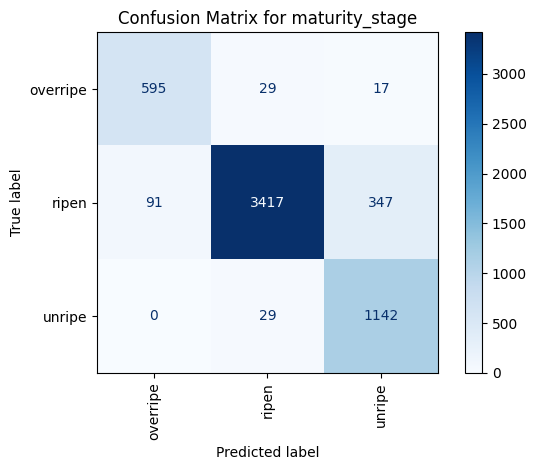

178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step


<Figure size 1200x1000 with 0 Axes>

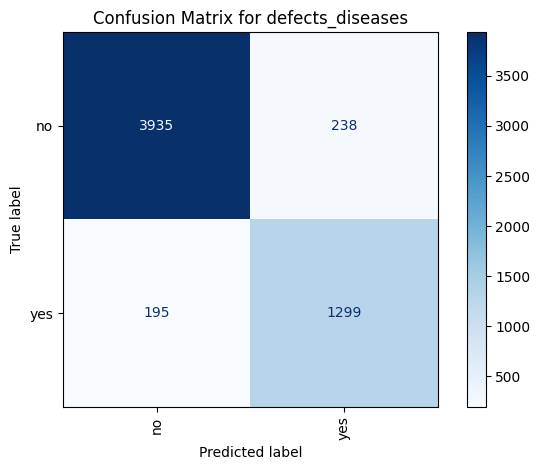

178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step


<Figure size 1200x1000 with 0 Axes>

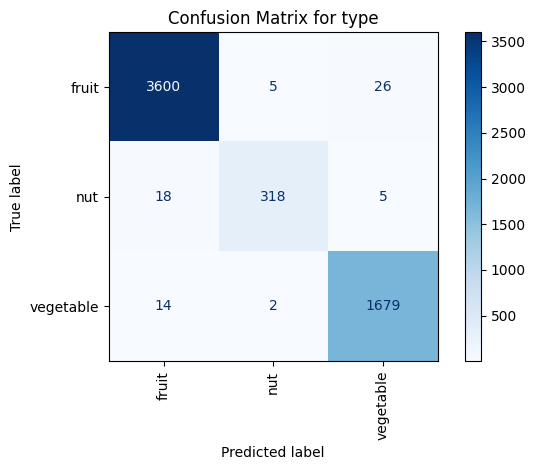

178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


<Figure size 1200x1000 with 0 Axes>

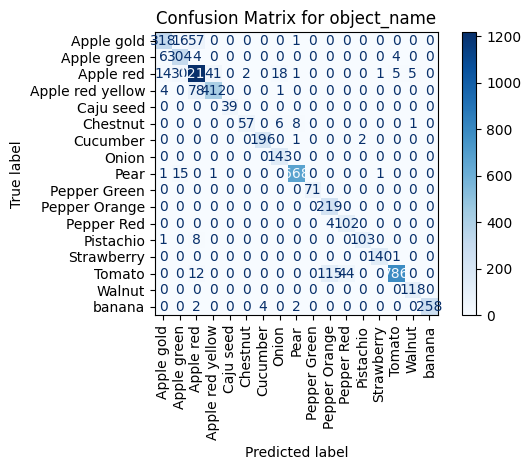

In [117]:
def plot_confusion_matrix(model, dataset, target_name, class_names):
    """
    Plots the confusion matrix for a specific output of the multi-output model.

    Args:
        model (tf.keras.Model): The trained multi-output model.
        dataset (tf.data.Dataset): The dataset to evaluate on.
        target_name (str): The name of the target output (e.g., 'object_name').
        class_names (list): A list of class names for the target output.
    """
    predictions = model.predict(dataset)
    true_labels = []

    # Iterate through the dataset to get true labels for the specific target
    for _, labels in dataset:
        true_labels.extend(labels[target_name].numpy())

    true_y = np.array(true_labels)
    pred_y = predictions[target_name]

    if pred_y.shape[-1] == 1: # Binary classification
        pred_y_classes = (pred_y > 0.5).astype(int).flatten()
    else: # Multiclass classification
        pred_y_classes = np.argmax(pred_y, axis=1)

    # Ensure we only consider classes that are present in the true labels or class names
    # and that both true and predicted labels only contain values within the range of class_names
    unique_true_y = np.unique(true_y)
    unique_pred_y = np.unique(pred_y_classes)

    # Identify actual classes present in either true or predicted labels
    present_classes_indices = np.union1d(unique_true_y, unique_pred_y)
    present_class_names = [class_names[i] for i in present_classes_indices if i < len(class_names)]

    # Filter true and predicted labels to only include indices that correspond to present_classes_indices
    # This step might not be necessary if the predictions and true labels are always within expected range
    # based on the dataset and model structure, but it's a safeguard.
    # A simpler approach is to ensure true_y and pred_y_classes only contain indices that are valid for class_names.
    valid_indices = np.arange(len(class_names))
    true_y_filtered = true_y[np.isin(true_y, valid_indices)]
    pred_y_classes_filtered = pred_y_classes[np.isin(pred_y_classes, valid_indices)]

    if len(true_y_filtered) == 0 or len(pred_y_classes_filtered) == 0:
         print(f"No valid samples found for {target_name} to plot confusion matrix.")
         return

    # Recalculate confusion matrix using filtered labels and only consider classes present in the data
    cm = confusion_matrix(true_y_filtered, pred_y_classes_filtered, labels=present_classes_indices)

    plt.figure(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=present_class_names)

    # Use a different plot function that handles display_labels correctly
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f'Confusion Matrix for {target_name}')
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for each target output on the test set
for target_name, class_names in target_names_dict.items():
    plot_confusion_matrix(model, test_ds, target_name, class_names)

In [108]:
import pickle

# To save the encoders as well for prediction
encoders = {
    'maturity_stage': encoder_maturity,
    'defects_diseases': encoder_defects,
    'type': encoder_type,
    'object_name': encoder_object
}

encoders_filename = 'encoders.pkl'
with open(encoders_filename, 'wb') as f:
    pickle.dump(encoders, f)

print(f"Encoders saved as {encoders_filename}")


Encoders saved as encoders.pkl


In [130]:
def preprocess_image(path):
  # Load the image first
  img = Image.open(path).convert('RGB')
  # Display the loaded image
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  # Continue with the rest of the preprocessing
  img = img.resize(IMG_SIZE)
  arr = np.asarray(img) / 255.0
  img_for_prediction = np.expand_dims(arr, 0) # Use a different variable name to avoid confusion
  preds = model.predict(img_for_prediction)

  for task in preds:
      # The output of model.predict is a dictionary with task names as keys.
      # Each value is a numpy array with the predictions for that task.
      # For classification tasks with softmax/sigmoid, the output shape will be (batch_size, num_classes)
      # or (batch_size, 1) for binary. We are predicting for a single image (batch_size=1),
      # so we access the prediction probabilities for this single image using preds[task][0].

      if task == 'maturity_stage':
          probabilities = preds[task][0] # Get the probabilities for all classes
          predicted_class_index = np.argmax(probabilities)
          # Ensure the predicted_class_index is within the bounds of maturity_classes
          if 0 <= predicted_class_index < len(maturity_classes):
              predicted_class_label = maturity_classes[predicted_class_index]
              print(f"{task}: {predicted_class_label} (Probability: {probabilities[predicted_class_index]:.4f})")
          else:
              print(f"Warning: Predicted index {predicted_class_index} is out of bounds for {task}. Available classes: {maturity_classes}")
      elif task == 'defects_diseases':
          # For the binary case with 'sigmoid', the output is a single value between 0 and 1.
          prediction_probability = preds[task][0][0] # Get the single probability value
          predicted_class_index = 1 if prediction_probability >= 0.5 else 0 # 1 for 'yes', 0 for 'no'

          # Ensure the predicted_class_index is within the bounds of defects_classes
          if 0 <= predicted_class_index < len(defects_classes):
              predicted_class_label = defects_classes[predicted_class_index]
              print(f"{task}: {predicted_class_label} (Probability: {prediction_probability:.4f})")
          else:
               # This case should ideally not happen with the 0/1 threshold, but included for safety
              print(f"Warning: Predicted index {predicted_class_index} is out of bounds for {task}. Available classes: {defects_classes}")

      elif task == 'type':
          probabilities = preds[task][0] # Get the probabilities for all classes
          predicted_class_index = np.argmax(probabilities)
          # Ensure the predicted_class_index is within the bounds of type_classes
          if 0 <= predicted_class_index < len(type_classes):
              predicted_class_label = type_classes[predicted_class_index]
              print(f"{task}: {predicted_class_label} (Probability: {probabilities[predicted_class_index]:.4f})")
          else:
              print(f"Warning: Predicted index {predicted_class_index} is out of bounds for {task}. Available classes: {type_classes}")
      elif task == 'object_name':
          probabilities = preds[task][0] # Get the probabilities for all classes
          predicted_class_index = np.argmax(probabilities)
          # Ensure the predicted_class_index is within the bounds of object_classes
          if 0 <= predicted_class_index < len(object_classes):
              predicted_class_label = object_classes[predicted_class_index]
              print(f"{task}: {predicted_class_label} (Probability: {probabilities[predicted_class_index]:.4f})")
          else:
              print(f"Warning: Predicted index {predicted_class_index} is out of bounds for {task}. Available classes: {object_classes}")

In [110]:
# Path to the zip file
zip_file_path = '/content/test_data.zip'

# Directory to extract the contents
extract_dir = '/content/test_data_extracted'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Successfully unzipped {zip_file_path} to {extract_dir}")


Successfully unzipped /content/test_data.zip to /content/test_data_extracted


Processing images from: /content/test_data_extracted

Processing image: /content/test_data_extracted/test_data/istockphoto-528532355-612x612.jpg


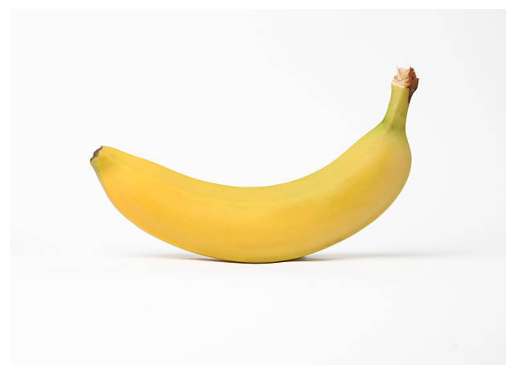

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
defects_diseases: no (Probability: 0.0042)
type: fruit (Probability: 0.9990)
maturity_stage: unripe (Probability: 0.9908)
object_name: banana (Probability: 0.9982)

Processing image: /content/test_data_extracted/test_data/jpbi7xXH22fAxKvrF4bzzd-1200-80.jpg


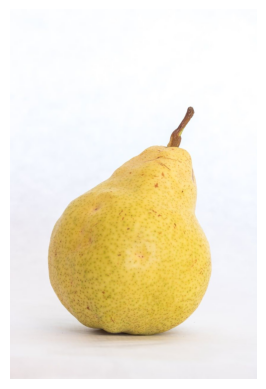

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
defects_diseases: no (Probability: 0.0043)
type: fruit (Probability: 0.9999)
maturity_stage: ripen (Probability: 0.9989)
object_name: Pear (Probability: 0.9987)

Processing image: /content/test_data_extracted/test_data/RHS_SCN0000159_823776_2.jpg


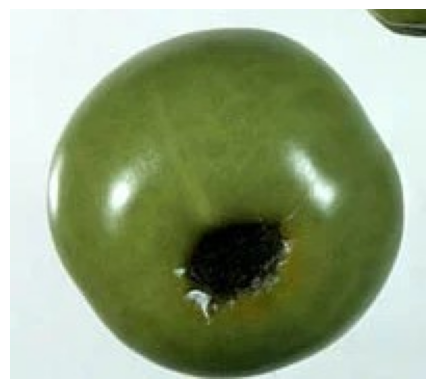

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
defects_diseases: no (Probability: 0.0363)
type: vegetable (Probability: 0.9356)
maturity_stage: unripe (Probability: 0.9294)
object_name: Tomato (Probability: 0.9410)

Processing image: /content/test_data_extracted/test_data/Severe-bloth-pit_WA38_WEJ.jpg


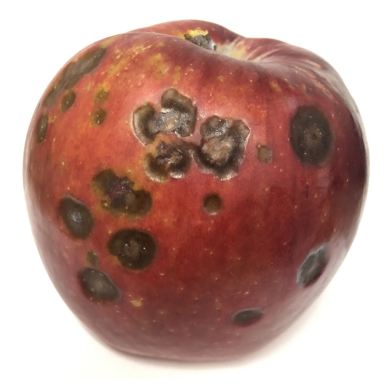

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
defects_diseases: yes (Probability: 0.9652)
type: fruit (Probability: 0.8934)
maturity_stage: ripen (Probability: 0.7208)
object_name: Apple red (Probability: 0.8020)

Processing image: /content/test_data_extracted/test_data/1918.jpg


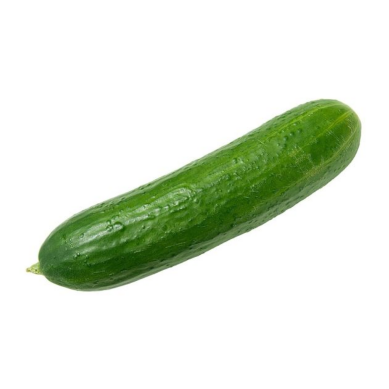

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
defects_diseases: no (Probability: 0.3246)
type: vegetable (Probability: 0.9925)
maturity_stage: ripen (Probability: 0.9724)
object_name: Cucumber (Probability: 0.9993)

Processing image: /content/test_data_extracted/test_data/pomodoro-tondo.png


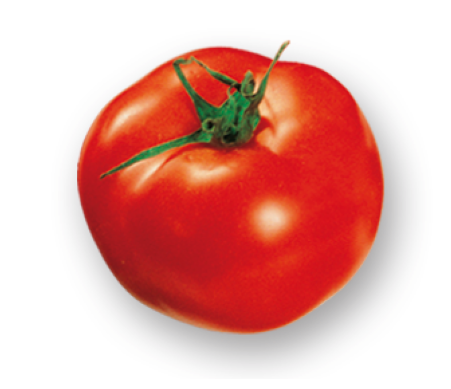

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
defects_diseases: no (Probability: 0.0001)
type: vegetable (Probability: 0.9993)
maturity_stage: ripen (Probability: 0.9997)
object_name: Tomato (Probability: 0.9997)

Processing image: /content/test_data_extracted/test_data/RF-10008-RIPE-ORGANIC-ORGANIC-APPLE-GALA.jpg


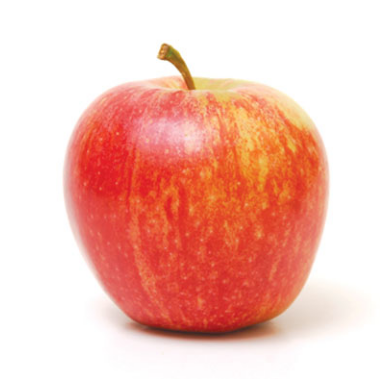

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
defects_diseases: no (Probability: 0.0021)
type: fruit (Probability: 0.9951)
maturity_stage: ripen (Probability: 0.9074)
object_name: Apple red yellow (Probability: 0.9778)

Processing image: /content/test_data_extracted/test_data/360_F_59967553_9g2bvhTZf18zCmEVWcKigEoevGzFqXzq.jpg


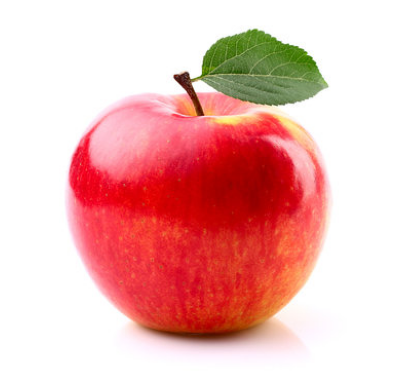

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
defects_diseases: no (Probability: 0.0312)
type: fruit (Probability: 0.8860)
maturity_stage: ripen (Probability: 0.8293)
object_name: Apple red yellow (Probability: 0.8318)

Processing image: /content/test_data_extracted/test_data/images (3).jpeg


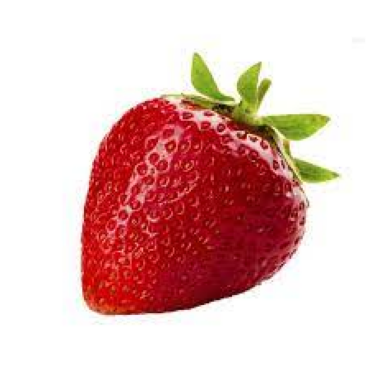

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
defects_diseases: no (Probability: 0.0224)
type: fruit (Probability: 1.0000)
maturity_stage: ripen (Probability: 0.9999)
object_name: Strawberry (Probability: 1.0000)


In [132]:
# Loop over the extracted files and apply preprocess_image function
# Use os.walk to traverse directories and find image files
image_extensions = ('.jpg', '.jpeg', '.png')

print(f"Processing images from: {extract_dir}")
for dirpath, dirnames, filenames in os.walk(extract_dir):
    for filename in filenames:
        if filename.lower().endswith(image_extensions):
            image_path = os.path.join(dirpath, filename)
            print(f"\nProcessing image: {image_path}")
            preprocess_image(image_path)
